# Análisis predictivo COVID-19
## Entrega Final - Analítica predictiva
## Universidad Nacional de Colombia
**Andres Cadavid, Gabriela Chamorro y Jose Luis Cossio**

### Importar paquetes requeridos

In [1]:
import requests
import pandas as pd
from datetime import date
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

### Extracción de datos

In [2]:
def extract_data(api_url, limit):
    # Funcion para la extraccion de los datos via SODA API ODATA
    data_len = 50000
    offset = 0
    appended_data = []
    while data_len >= limit:
        time.sleep(1)
        params = {'$limit': limit, '$offset': offset}
        response = requests.get(api_url, params=params)
        data = response.json()
        data_len = len(data)
        if 'error' not in data or len(data) > 0:
            df = pd.DataFrame.from_dict(data, orient='columns')
            df['extracted_at_utc'] = pd.to_datetime('now', utc=True)
            appended_data.append(df)
            offset = offset + limit
    return pd.concat(appended_data, ignore_index=True, sort=False)

### Transformación de datos

In [3]:
def data_transform(df, start_date):
    # Funcion transformacion de los datos (Data quality)
    df_in = df
    if 'atenci_n' in df.columns:
        df_in['atenci_n'] = df['atenci_n'].str.strip()
        df_in['atenci_n'] = df['atenci_n'].str.lower()
    delta = date.today() - start_date
    df_dates = pd.DataFrame(pd.date_range(start_date, periods=delta.days, freq='D'), columns=['fecha'])
    df_in['fecha_de_notificaci_n'] = pd.to_datetime(df_in['fecha_de_notificaci_n'])
    df_in['fecha_de_muerte'] = pd.to_datetime(df_in['fecha_de_muerte'])
    df_in['fecha_recuperado'] = pd.to_datetime(df_in['fecha_recuperado'])
    df_in['fecha_diagnostico'] = pd.to_datetime(df_in['fecha_diagnostico'])
    return df_in, df_dates


def data_agg_col(df, df_dates, city_filter):
    # Funcion para realizar agregaciones
    if city_filter is None:
        df_filtered = df
    else:
        df_filtered = df.loc[df['ciudad_de_ubicaci_n'].isin(city_filter)]
    df_filtered['c_recuperado'] = df_filtered['atenci_n'].apply(lambda x : 1 if x == 'recuperado' else 0)
    df_filtered['c_fallecido'] = df_filtered['atenci_n'].apply(lambda x: 1 if x == 'fallecido' else 0)
    df_filtered['c_caso'] = 1
    df_casos = df_filtered.groupby(['fecha_diagnostico'], as_index=False)['c_caso'].sum()
    df_casos = df_casos.rename(columns={'fecha_diagnostico': 'fecha'})
    df_muertes = df_filtered.groupby(['fecha_de_muerte'], as_index=False)['c_fallecido'].sum()
    df_muertes = df_muertes.rename(columns={'fecha_de_muerte':'fecha'})
    df_recuperados = df_filtered.groupby(['fecha_recuperado'], as_index=False)['c_recuperado'].sum()
    df_recuperados = df_recuperados.rename(columns={'fecha_recuperado': 'fecha'})
    df_full = pd.merge(df_dates, df_casos, how='left', on=['fecha'])
    df_full = pd.merge(df_full, df_muertes, how='left', on=['fecha'])
    df_full = pd.merge(df_full, df_recuperados, how='left', on=['fecha'])
    return df_full

## ARIMA

### Evaluación del modelo ARIMA para obtener el mejor (p,d,q)

In [4]:
def evaluate_arima_model(X, arima_order, train_perc):
    # prepare training dataset
    train_size = int(len(X) * train_perc)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(arima_order))
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

### Evaluación de la combinación de valores de p, d y q para el modelo ARIMA

In [5]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order, 0.8)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [6]:
def data_prep_normalize(df_o):
    df = df_o.copy()
    df['casos_lag'] = df['c_caso'].shift(1)
    df['fallecidos_lag'] = df['c_fallecido'].shift(1)
    df['recuperados_lag'] = df['c_recuperado'].shift(1)
    df = df.replace({0: np.nan})
    df['casos_diff'] = (df['c_caso'] - df['casos_lag'])/df['casos_lag']
    df['fallecidos_diff'] = (df['c_fallecido'] - df['fallecidos_lag']) / df['fallecidos_lag']
    df['recuperados_diff'] = (df['c_recuperado'] - df['recuperados_lag']) / df['recuperados_lag']
    df['tasa_casos'] = df['casos_lag']/df['c_caso']
    df['tasa_fallecitos'] = df['fallecidos_lag']/df['c_fallecido']
    df['tasa_recuperados'] = df['recuperados_lag']/ df['c_recuperado']

    # Eliminacion de Outliers
    quant_95_casos = df['casos_diff'].quantile(.95)
    mean_casos = df['casos_diff'].mean()

    quant_95_fallecidos = df['fallecidos_diff'].quantile(.95)
    mean_fallecidos = df['fallecidos_diff'].mean()

    quant_95_recuperados = df['recuperados_diff'].quantile(.95)
    mean_recuperados = df['recuperados_diff'].mean()

    df['casos_diff'] = df['casos_diff'].apply(lambda x: x if x <= quant_95_casos else mean_casos)
    df['fallecidos_diff'] = df['fallecidos_diff'].apply(lambda x: x if x <= quant_95_fallecidos else mean_fallecidos)
    df['recuperados_diff'] = df['recuperados_diff'].apply(lambda x: x if x <= quant_95_recuperados else mean_recuperados)

    df = df.fillna(0)
    # Eliminacion de outliers ultimas fechas por datos faltantes desde la fuente
    df.drop(df.tail(2).index, inplace=True)
    return df

In [7]:
def arima_model_imp(df, train_perc, pred_range, ranges_casos, ranges_recu, ranges_fall):
    df_entrenamiento = df[['fecha', 'casos_diff']].iloc[:int(round((len(df) * train_perc) - 1, 0))]
    df_entrenamiento_recu = df[['fecha', 'recuperados_diff']].iloc[:int(round((len(df) * train_perc) - 1, 0))]
    df_entrenamiento_fall = df[['fecha', 'fallecidos_diff']].iloc[:int(round((len(df) * train_perc) - 1, 0))]
    serie_entrenamienti = df_entrenamiento.set_index('fecha')
    serie_entrenamienti_recu = df_entrenamiento_recu.set_index('fecha')
    serie_entrenamienti_fall = df_entrenamiento_fall.set_index('fecha')

    model_casos = ARIMA(serie_entrenamienti['casos_diff'], order=(ranges_casos))
    model_fit_casos = model_casos.fit(disp=0)
    model_recu = ARIMA(serie_entrenamienti_recu['recuperados_diff'], order=(ranges_recu))
    model_fit_recu = model_recu.fit(disp=0)
    model_fall = ARIMA(serie_entrenamienti_fall['fallecidos_diff'], order=(ranges_fall))
    model_fit_fall = model_fall.fit(disp=0)
    # Pronosticos corto plazo
    yhat_corto_casos = model_fit_casos.forecast(steps=pred_range[0])[0]
    yhat_corto_recuperados = model_fit_recu.forecast(steps=pred_range[0])[0]
    yhat_corto_fallecidos = model_fit_fall.forecast(steps=pred_range[0])[0]
    # Pronosticos largo plazo
    yhat_largo_casos = model_fit_casos.forecast(steps=pred_range[1])[0]
    yhat_largo_recuperados = model_fit_recu.forecast(steps=pred_range[1])[0]
    yhat_largo_fallecidos = model_fit_fall.forecast(steps=pred_range[1])[0]
    response = [
        {'pronostico_corto_casos': yhat_corto_casos,
         'pronostico_largo_casos': yhat_largo_casos},
        {'pronostico_corto_recuperados': yhat_corto_recuperados,
         'pronostico_largo_recuperados': yhat_largo_recuperados},
        {'pronostico_corto_fallecidos': yhat_corto_fallecidos,
         'pronostico_largo_fallecidos': yhat_largo_fallecidos},
                ]
    return response

In [8]:
def error_calculation(df, train_perc,range_c, range_rec, range_fall):
    serie_casos = df.set_index('fecha')
    serie_recuperados = df.set_index('fecha')
    serie_fallecidos = df.set_index('fecha')
    error_casos = evaluate_arima_model(serie_casos['casos_diff'], range_c, train_perc)
    error_recu = evaluate_arima_model(serie_recuperados['recuperados_diff'], range_rec, train_perc)
    error_fall = evaluate_arima_model(serie_fallecidos['fallecidos_diff'], range_fall, train_perc)
    response = [
        {'error_casos': error_casos},
        {'error_recuperados': error_recu},
        {'error_fallecidos': error_fall}

    ]
    return response

In [9]:
def translate_prediction(last_value_base, y_pred):
    temp_val = last_value_base
    trans_values = []
    for val in y_pred:
        new_t_val = temp_val*(1 + val)
        trans_values.append(new_t_val)
        temp_val = new_t_val
    return trans_values

In [10]:
api_url = "https://www.datos.gov.co/resource/gt2j-8ykr.json"
df_casos = extract_data(api_url, 50000)
df_casos, df_dates = data_transform(df_casos,date(2020,3,1))

In [15]:
df_full = data_agg_col(df_casos, df_dates, None)
df_full_medellin = data_agg_col(df_casos, df_dates, ['Medellín'])
df_full_bogota = data_agg_col(df_casos, df_dates, ['Bogotá D.C.'])
df_full_cartagena = data_agg_col(df_casos, df_dates, ['Cartagena de Indias'])
df_full_cali = data_agg_col(df_casos, df_dates, ['Cali'])
df_full_barranquilla = data_agg_col(df_casos, df_dates, ['Barranquilla'])


/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

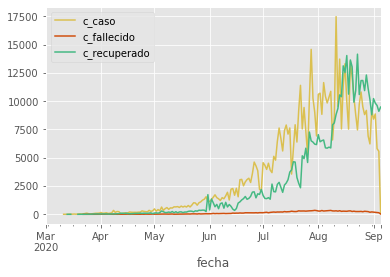

In [14]:
plt.style.use('ggplot')
df_full.plot(x='fecha',
        y=['c_caso', 'c_fallecido', 'c_recuperado'],
        color=['#dbc050', '#d04f0e', '#45b983'],
        kind='line')

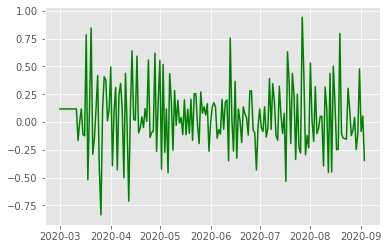

In [19]:
df_norm_col = data_prep_normalize(df_full)
df_norm_medellin = data_prep_normalize(df_full_medellin)
df_norm_bogota = data_prep_normalize(df_full_bogota)
df_norm_cartagena = data_prep_normalize(df_full_cartagena)
df_norm_cali = data_prep_normalize(df_full_cali)
df_norm_barranquilla = data_prep_normalize(df_full_barranquilla)
# Visualizar la distribucion de los datos graficamente posterior a la normalizacion
plt.plot(df_norm_col['fecha'],df_norm_col['casos_diff'], '-g')

Text(0.5, 0, 'Fecha')

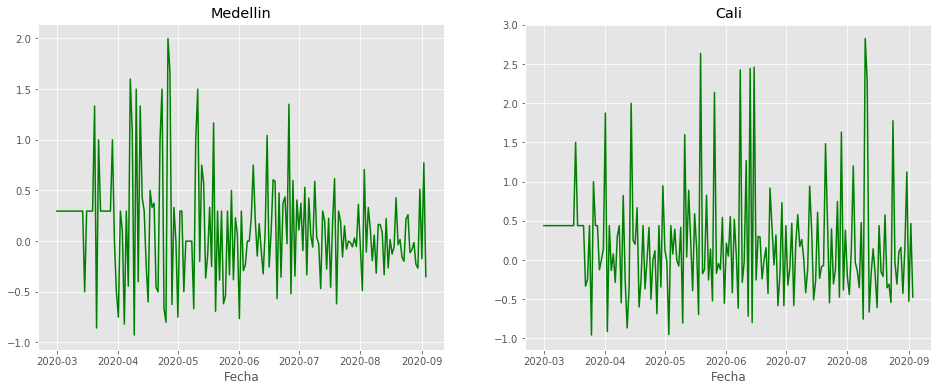

In [21]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2 , 1)
plt.plot(df_norm_medellin['fecha'],df_norm_medellin['casos_diff'], '-g')
plt.title('Medellin')
plt.xlabel('Fecha')
plt.subplot(1, 2 , 2)
plt.plot(df_norm_cali['fecha'],df_norm_cali['casos_diff'], '-g')
plt.title('Cali')
plt.xlabel('Fecha')

Text(0.5, 0, 'Fecha')

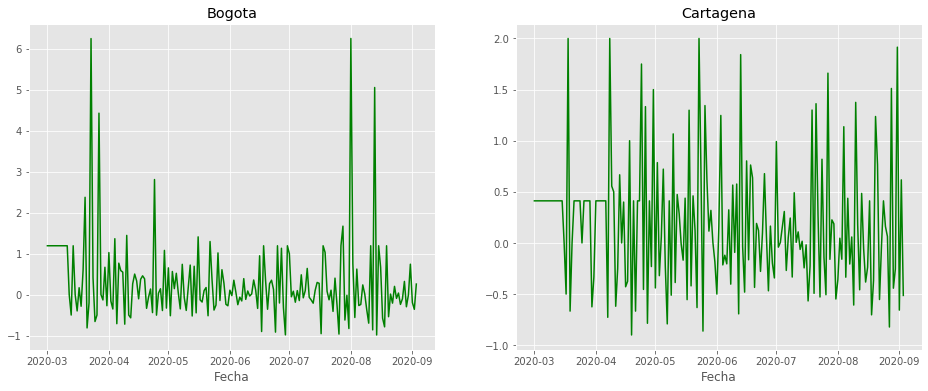

In [22]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2 , 1)
plt.plot(df_norm_bogota['fecha'],df_norm_bogota['casos_diff'], '-g')
plt.title('Bogota')
plt.xlabel('Fecha')
plt.subplot(1, 2 , 2)
plt.plot(df_norm_cartagena['fecha'],df_norm_cartagena['casos_diff'], '-g')
plt.title('Cartagena')
plt.xlabel('Fecha')

In [23]:
df_full.describe()

,c_caso,c_fallecido,c_recuperado
count,181.000000,169.000000,175.000000
mean,3615.883978,125.183432,2901.542857
std,4114.501462,114.949298,3965.982444
min,1.000000,1.000000,1.000000
25%,236.000000,18.000000,101.000000
50%,1472.000000,80.000000,880.000000
75%,6924.000000,245.000000,4784.000000
max,17466.000000,352.000000,14151.000000


In [24]:
df_norm_col.describe()

,c_caso,c_fallecido,c_recuperado,casos_lag,fallecidos_lag,recuperados_lag,casos_diff,fallecidos_diff,recuperados_diff,tasa_casos,tasa_fallecitos,tasa_recuperados
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,3469.711230,112.197861,2616.010695,3438.668449,111.294118,2564.572193,0.049647,0.030127,0.052223,0.983751,0.918422,0.917293
std,4103.150151,115.776056,3850.585780,4107.344311,115.989683,3820.664585,0.294995,0.222413,0.249750,0.582629,0.578449,0.483733
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.836066,-0.800000,-0.777906,0.000000,0.000000,0.000000
25%,183.000000,11.000000,78.000000,178.000000,10.500000,75.000000,-0.121984,-0.062500,-0.088492,0.737858,0.795833,0.763790
50%,1292.000000,55.000000,457.000000,1267.000000,52.000000,386.000000,0.050925,0.055556,0.069219,0.951543,0.947368,0.935262
75%,6804.500000,225.000000,3495.000000,6804.500000,225.000000,3159.000000,0.196489,0.101583,0.137613,1.138931,1.066667,1.097085
max,17466.000000,352.000000,14151.000000,17466.000000,352.000000,14151.000000,0.943249,0.666667,0.895372,6.100000,5.000000,4.502591


## Entrenamiendo del modelo y selección de los mejores parametros p, d y q para casos, recuperados y fallecidos

In [26]:
p = [0,1,3]
d = [0,1]
q = [0,1,3]
#df_entrenamiento = df_norm_cali[['fecha', 'fallecidos_diff']].iloc[:int(round((len(df_norm_medellin) * 0.8) - 1, 0))]
test = df_norm_col.set_index('fecha')
evaluate_models(test['casos_diff'], p, d, q)

ARIMA(0, 0, 0) MSE=0.090
ARIMA(0, 0, 1) MSE=0.077
ARIMA(0, 0, 3) MSE=0.074


/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0) MSE=0.243


/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1) MSE=0.090


/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0) MSE=0.086
ARIMA(1, 0, 1) MSE=0.076
ARIMA(1, 0, 3) MSE=0.079


/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0) MSE=0.176


/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:221: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-pa

ARIMA(1, 1, 3) MSE=0.075
ARIMA(3, 0, 0) MSE=0.078


/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 1) MSE=0.082


/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overfl

ARIMA(3, 0, 3) MSE=0.085
ARIMA(3, 1, 0) MSE=0.127
ARIMA(3, 1, 1) MSE=0.077


/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_di

Best ARIMA(0, 0, 3) MSE=0.074


/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


In [27]:
response_col = arima_model_imp(df_norm_col, 0.8, [7, 15], [4, 0, 0], [3, 1, 0], [1, 1, 3])

/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarni

In [28]:
response_med = arima_model_imp(df_norm_medellin, 0.8, [7, 15], [1, 1, 3], [1, 1, 1], [3, 1, 1])

/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarni

In [29]:
response_bog = arima_model_imp(df_norm_bogota, 0.8, [7, 15], [0, 0, 1], [0, 0, 0], [3, 1, 1])

/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [30]:
response_cal = arima_model_imp(df_norm_cali, 0.8, [7, 15], [0, 0, 0], [1, 1, 1], [3, 1, 1])

/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarni

In [31]:
response_car = arima_model_imp(df_norm_cartagena, 0.8, [7, 15], [1, 1, 3], [1, 1, 3], [1, 0, 1])

/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:221: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information

In [32]:
response_bar = arima_model_imp(df_norm_barranquilla, 0.8, [7, 15], [4, 0, 0], [1, 1, 3], [0, 0, 1])

/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


### Traducción de problema analítico a problema real

In [78]:
response_col['pronostico_corto_casos']

TypeError: list indices must be integers or slices, not str

In [36]:
last_real_val_casos_med = response_med.tail(1)['c_caso'].values[0]
last_real_val_rec_med = response_med.tail(1)['c_recuperado'].values[0]
last_real_val_fall_med = response_med.tail(1)['c_fallecido'].values[0]

response_med[0]['corto_plazo_translate'] = translate_prediction(last_real_val_casos_col, response_med[0]['pronostico_corto_casos'])
response_med[1]['corto_plazo_translate'] = translate_prediction(last_real_val_rec_col, response_med[1]['pronostico_corto_recuperados'])
response_med[2]['corto_plazo_translate'] = translate_prediction(last_real_val_fall_col, response_med[2]['pronostico_corto_fallecidos'])

response_med[0]['largo_plazo_translate'] = translate_prediction(last_real_val_casos_col, response_med[0]['pronostico_largo_casos'])
response_med[1]['largo_plazo_translate'] = translate_prediction(last_real_val_rec_col, response_med[1]['pronostico_largo_recuperados'])
response_med[2]['largo_plazo_translate'] = translate_prediction(last_real_val_fall_col, response_med[2]['pronostico_largo_fallecidos'])


AttributeError: 'list' object has no attribute 'tail'

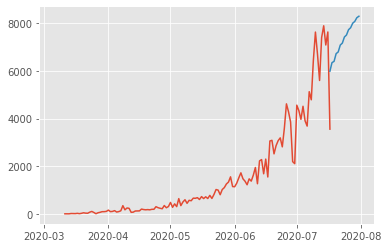

In [76]:
df_full.drop(df_full.tail(2).index, inplace=True)

real_series = pd.Series(df_full['c_caso'].values, index=df_full['fecha'])
plt.plot(real_series)

n_periods = 15
index_of_fc = pd.date_range(real_series.index[-1], periods = n_periods, freq='D')
fitted_series = pd.Series(translate_prediction(last_real_val_casos_col, response_med[0]['pronostico_largo_casos']), index=index_of_fc)
plt.plot(fitted_series)

In [75]:
response_med

[{'pronostico_corto_casos': array([0.0312353 , 0.06009463, 0.00833817, 0.05063638, 0.01053322,
         0.04262196, 0.01146331]),
  'pronostico_largo_casos': array([0.0312353 , 0.06009463, 0.00833817, 0.05063638, 0.01053322,
         0.04262196, 0.01146331, 0.03571576, 0.0114225 , 0.02966018,
         0.01063647, 0.02425749, 0.00927843, 0.01935593, 0.00748135])},
 {'pronostico_corto_recuperados': array([0.07669165, 0.1404575 , 0.11969909, 0.12446834, 0.12152783,
         0.12091579, 0.11960052]),
  'pronostico_largo_recuperados': array([0.07669165, 0.1404575 , 0.11969909, 0.12446834, 0.12152783,
         0.12091579, 0.11960052, 0.11849764, 0.11733061, 0.11618295,
         0.11502944, 0.1138777 , 0.11272543, 0.11157332, 0.11042115])},
 {'pronostico_corto_fallecidos': array([0.31069292, 0.0974895 , 0.06020428, 0.17040333, 0.09571511,
         0.12550255, 0.125121  ]),
  'pronostico_largo_fallecidos': array([0.31069292, 0.0974895 , 0.06020428, 0.17040333, 0.09571511,
         0.12550255, 

In [48]:
translate_prediction(last_real_val_casos_col, response_med[0]['pronostico_corto_casos'])

[5986.320918272017,
 6346.066635731113,
 6398.9812414165335,
 6723.002474808187,
 6793.817305445933,
 7083.383130765651,
 7164.582172972626]

In [42]:
df_full

,fecha,c_caso,c_fallecido,c_recuperado
0,2020-03-01,NaN,NaN,NaN
1,2020-03-02,NaN,NaN,NaN
2,2020-03-03,NaN,NaN,NaN
3,2020-03-04,NaN,NaN,NaN
4,2020-03-05,NaN,NaN,NaN
...,...,...,...,...
184,2020-09-01,8411.0,195.0,10227.0
185,2020-09-02,8869.0,175.0,9825.0
186,2020-09-03,5805.0,169.0,9619.0
187,2020-09-04,5568.0,141.0,9100.0


In [159]:
translate_prediction(last_real_val_casos_col, response_col['pronostico_corto_casos']['pronostico_corto_casos'])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [29]:
df_entrenamiento = df_full[['fecha', 'casos_diff']].iloc[:int(round((len(df_full) * 0.8) - 1, 0))]
test = df_entrenamiento.set_index('fecha')
#p_v = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
p_v = [0,3,5]
d_v = [0,1]
q_v = [0,3,5]
#q_v = [0,1,2,3,4,5,6,7,8,9,10]
#evaluate_models(test['casos_diff'],p_v,d_v,q_v)
error = evaluate_arima_model(test['casos_diff'], [5,0,0])
model = ARIMA(test['casos_diff'], order=(5, 0, 0))
model_fit = model.fit(disp=0)
# Pronostico proximos 7 dias
yhat7 = model_fit.forecast(steps=7)[0]
# Pronostico proximos 30 dias
yhat30 = model_fit.forecast(steps=30)[0]

/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [30]:
yhat7

array([ 0.03958113, -0.01857169,  0.02791094,  0.04312991,  0.0329232 ,
        0.04401463,  0.042103  ])

In [ ]:
plt.plot(df_full['fecha'],df_full['casos_diff'])

In [31]:
yhat30

array([ 0.03958113, -0.01857169,  0.02791094,  0.04312991,  0.0329232 ,
        0.04401463,  0.042103  ,  0.03787696,  0.03829767,  0.03879219,
        0.03857615,  0.03888414,  0.03899081,  0.0388737 ,  0.03884672,
        0.03885314,  0.03884402,  0.03885022,  0.03885752,  0.0388564 ,
        0.03885517,  0.03885503,  0.03885456,  0.03885452,  0.03885476,
        0.03885483,  0.03885481,  0.03885481,  0.03885479,  0.03885478])

## LR+MLP

In [85]:
df_filtrado = df_full[['fecha', 'c_caso']]
df_filtrado 

,fecha,c_caso
0,2020-03-01,NaN
1,2020-03-02,NaN
2,2020-03-03,NaN
3,2020-03-04,NaN
4,2020-03-05,NaN
...,...,...
184,2020-09-01,8411.0
185,2020-09-02,8869.0
186,2020-09-03,5805.0
187,2020-09-04,5568.0


In [13]:
df_filtrado = df_full[['fecha', 'casos_diff']]
df_filtrado 

,fecha,casos_diff
0,2020-03-01,0.000000
1,2020-03-02,0.000000
2,2020-03-03,0.000000
3,2020-03-04,0.000000
4,2020-03-05,0.000000
...,...,...
181,2020-08-29,0.327624
182,2020-08-30,0.107913
183,2020-08-31,-0.318127
184,2020-09-01,0.094849


In [16]:
x = np.array(df_filtrado.index)
y = np.array(df_filtrado['casos_diff'])

In [79]:
%clear
import tensorflow as tf
import numpy as np
##
## Parametros
##
H = 3
learning_rate=0.01
max_iter=1000

In [18]:
##
## Datos
##
X = [[u] for u in x]
N = len(X[0])
P = len(X)

X_ = tf.constant(X, dtype=np.float32)
d_ = tf.constant(y, dtype=np.float32, shape=[len(y), 1])

In [19]:
##
## Info pronostico
##
Xpred = np.linspace(np.min(x), np.max(x), 50, dtype=np.float32)
Xpred = [[u] for u in Xpred]
Xpred_ = tf.constant(Xpred)

In [20]:
##
## Parámetros
##
intercept = tf.Variable(0.1 * np.mean(y),            dtype=np.float32)
WHOparams = tf.Variable(0.1 * np.random.randn(H, 1), dtype=np.float32)
WIHparams = tf.Variable(0.1 * np.random.randn(N, H), dtype=np.float32)
BHparams  = tf.Variable(0.1 * np.random.randn(H, 1), dtype=np.float32)


In [21]:
##
## Propagación de la señal
##
In_hidden = tf.add(tf.matmul(X_, WIHparams),
                   tf.tile(tf.transpose(BHparams), [P, 1]))
Out_hidden = tf.sigmoid(In_hidden)
MLP_output = tf.matmul(Out_hidden, WHOparams)
model_output = tf.add(intercept, MLP_output)

In [64]:
var = tf.Variable(d_)
y_ = tf.constant(y, dtype=np.float32)

In [53]:
##
## Función de error
##
SSE = tf.reduce_sum(tf.square(d_ - model_output)) # sum of the squared errors

In [51]:
opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
loss = lambda: 3 * var
opt.minimize(loss, var_list=[var])

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [65]:
w = tf.Variable(y_)
#w = tf.constant(w_, dtype=np.float32)
SSE = lambda: sum((var - w)**2)

In [66]:
##
## Optimizador
##
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)
optimizer.minimize(SSE,var_list=[var,w])

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [67]:
##
## Pronostico
##
In_hidden = tf.add(tf.matmul(Xpred_, WIHparams),
                   tf.tile(tf.transpose(BHparams), [len(Xpred), 1]))
Out_hidden = tf.sigmoid(In_hidden)
MLP_output = tf.matmul(Out_hidden, WHOparams)
ypred = tf.add(intercept, MLP_output)


In [94]:
import tensorflow.compat.v1 as tf

tf.compat.v1.global_variables_initializer()


In [95]:
##
## Ejecución
##
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(max_iter):
        sess.run(optimizer)
    p = sess.run(ypred)
    e = sess.run(SSE)

print('SSE = ', e)
plt.plot(x, d, 'o')
plt.plot(Xpred, p, '-')
plt.grid()

TypeError: Fetch argument <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fab3cc265d0> has invalid type <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>, must be a string or Tensor. (Can not convert a SGD into a Tensor or Operation.)

## SIR

In [86]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [87]:
# Funcion de maximizar (numero de infectados)
# N = poblacion total, beta = tasa de contacto y gamma = tasa de recuperación
def deriv(state, t, N, beta, gamma):
    S, I, R = state    
    dSdt = -beta * S * I / N    
    dIdt = beta * S * I / N - gamma * I    
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [92]:
df_full.c_caso.mean()

3615.8839779005525

In [93]:
df_full.c_recuperado.mean()

2901.542857142857

In [94]:
df_full.c_fallecido.mean()

125.18343195266272

In [95]:
df_full['c_caso'].mean()

3615.8839779005525

R0 is 2.8000000000000003


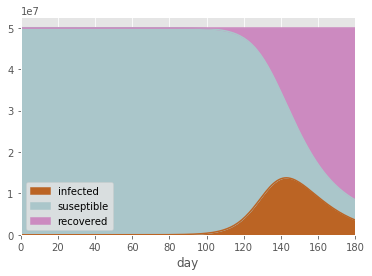

In [96]:
effective_contact_rate = 0.20 # beta
recovery_rate =  1/14 # gamma

print("R0 is", effective_contact_rate / recovery_rate)

# Condiciones iniciales para Colombia
total_pop = 50000000 # N
recovered = 0 
infected = 1
susceptible = total_pop - infected - recovered

# Dias, 0-181
days = range(0, 181)

ret = odeint(deriv,
             [susceptible, infected, recovered],
             days,
             args=(total_pop, effective_contact_rate, recovery_rate))
S, I, R = ret.T

# Construccion del dataframe
df = pd.DataFrame({
    'suseptible': S.round(),
    'infected': I.round(),
    'recovered': R.round(),
    'day': days
})

plt.style.use('ggplot')
df.plot(x='day',
        y=['infected', 'suseptible', 'recovered'],
        color=['#bb6424', '#aac6ca', '#cc8ac0'],
        kind='area',
        stacked=True)

## Evaluacion de modelos

In [97]:
df

,suseptible,infected,recovered,day
0,49999999.0,1.0,0.0,0
1,49999999.0,1.0,0.0,1
2,49999999.0,1.0,0.0,2
3,49999998.0,1.0,0.0,3
4,49999998.0,2.0,0.0,4
...,...,...,...,...
176,5185447.0,4347287.0,40467266.0,176
177,5098270.0,4131700.0,40770030.0,177
178,5016789.0,3925480.0,41057732.0,178
179,4940593.0,3728377.0,41331030.0,179


In [99]:
df['infected_'] = df_full.c_caso
df['recovered_'] = df_full.c_recuperado

In [100]:
df

,suseptible,infected,recovered,day,infected_,recovered_
0,49999999.0,1.0,0.0,0,NaN,NaN
1,49999999.0,1.0,0.0,1,NaN,NaN
2,49999999.0,1.0,0.0,2,NaN,NaN
3,49999998.0,1.0,0.0,3,NaN,NaN
4,49999998.0,2.0,0.0,4,NaN,NaN
...,...,...,...,...,...,...
176,5185447.0,4347287.0,40467266.0,176,9725.0,10580.0
177,5098270.0,4131700.0,40770030.0,177,10812.0,11819.0
178,5016789.0,3925480.0,41057732.0,178,9491.0,11825.0
179,4940593.0,3728377.0,41331030.0,179,8812.0,10930.0


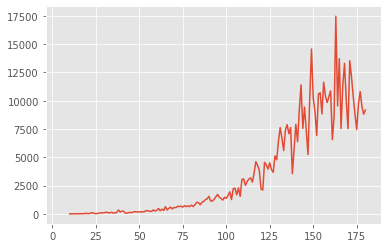

In [101]:
plt.plot(df['day'],df['infected_'])


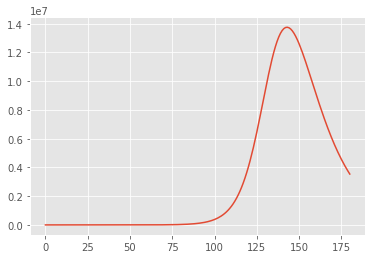

In [102]:
plt.plot(df['day'],df['infected'])

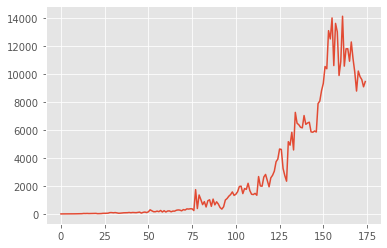

In [145]:
plt.plot(df['day'],df['recovered_'])

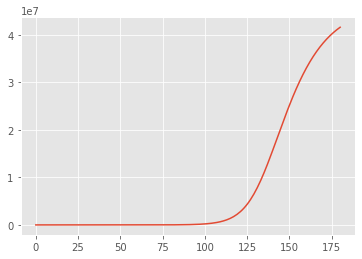

In [103]:
plt.plot(df['day'],df['recovered'])

## Conclusiones del análisis

## Trabajos futuros